# Volumetric rendering

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
W = 400 # width
H = 400 # height
f = 1200 #focal length

In [3]:
ray_origins = torch.zeros((H*W, 3)) # ray origins
ray_directions = torch.zeros((H*W, 3)) # ray directions

u = torch.arange(W) # pixel horizontal coordinate
v = torch.arange(H) # pixel vertical coordinate
u, v = torch.meshgrid(u, v, indexing='ij')

# direction vectors ()
directions = torch.stack((u - W / 2, # u to X axis
                -(v - H / 2), # v to Y axis (v goes on the opposite direction)
                -torch.ones_like(u) * f), # Z axis (goes on the opposite direction)
                axis=-1) # inverts coordinates order => dirs.shape -> (400, 400, 3)

ray_directions = directions / torch.linalg.norm(directions, axis=-1, keepdims=True) # normalized direction vectors
ray_directions = ray_directions.reshape(-1, 3) # reshape from (440, 400, 3) to (160000, 3)

In [4]:
class Sphere():

    def __init__(self, position, radius, color):
        self.position = position
        self.radius = radius
        self.color = color

    def intersect(self, x):
        # sphere volume equation
        # (x - xc)^2 + (y - yc)^2 + (z - zc)^2 <= r^2

        cond = (x[:, 0] - self.position[0]) ** 2 + \
            (x[:, 1] - self.position[1]) ** 2 + \
            (x[:, 2] - self.position[2]) ** 2 \
            <= self.radius ** 2

        num_rays = x.shape[0]
        colors = torch.zeros((num_rays, 3))
        density = torch.zeros((num_rays, 1))

        colors[cond] = self.color
        density[cond] = 10

        return colors, density

In [5]:
def compute_accumulated_transmitance(betas):
    accumulated_transmitance = torch.cumprod(betas, 1)
    accumulated_transmitance[:, 0] = 1.
    return accumulated_transmitance

def rendering(model, ray_origins, ray_directions, tn, tf, bin_count = 100, device = 'cpu'):

    t = torch.linspace(tn, tf, bin_count).to(device)
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10])))

    # [1, bin_count, 1]
    # [ray_count, 1, 3]

    x = ray_origins.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * ray_directions.unsqueeze(1) # [ray_count, bin_count, 3]

    colors, density = model.intersect(x.reshape(-1, 3))

    colors = colors.reshape((x.shape[0], bin_count, 3)) # [ray_count, bin_count, 3]
    density = density.reshape((x.shape[0], bin_count)) # 

    alpha = 1 - torch.exp(-density * delta.unsqueeze(0)) # from formula (3) of the paper, [ray_count, bin_count, 1]
    T = compute_accumulated_transmitance(1 - alpha) # [ray_count, bin_count, 1]
    color = (T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1) # [ray_count, 3]

    return color


In [6]:
model = Sphere(torch.tensor([0., 0., -1.]), 0.1, torch.tensor([1.0, 0., 0.])) # red spheres with center at origin and radius 0.1
px_colors = rendering(model, ray_origins, ray_directions, 0.8, 1.2)

In [7]:
image = px_colors.reshape(H, W, 3).cpu().numpy()

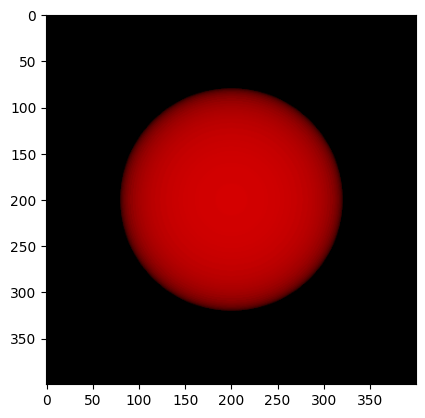

In [8]:
plt.imshow(image)